In [1]:
%load_ext autoreload
%load_ext autotime
%autoreload 2

## Imports & Settings

In [2]:
import os, sys
import warnings

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette('GnBu_r')
pd.options.display.max_rows = 300

from src import helper_functions as f
from src import visualizations as v
from src import class_Database as d
from src import class_Harness as h

from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, make_scorer, confusion_matrix, roc_auc_score)
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (BaggingClassifier, AdaBoostClassifier,
                              RandomForestClassifier, VotingClassifier)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sm_pipeline

# import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

time: 4.27 s


## Creating The Database

In [3]:
# creating database & database class instance
database_name = 'outcomes.db'
db = d.Database(database_name)

time: 12.9 ms


**Run The Cell Below Once And Then Comment Out**

In [4]:
# file_name = 'anonymisedData.zip'
# db.populate(file_name, database_name)

time: 534 µs


## Preprocessing and Harness Objects

In [5]:
string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number', dtype_exclude='object')

preprocessing_ohe = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector))
preprocessing_ss = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (StandardScaler(), number_selector))
sm = SMOTE(random_state=2021)

time: 1.14 ms


In [6]:
# creating accuracy scorer
accuracy = f.acc_score

# creating f1 scorer
f1 = f.f1

# creating recall scorer 
recall = f.recall

# creating precision scorer
precision = f.precision

# creating Harness
modeling = h.Harness(('accuracy', 'f1', 'recall', 'precision'))

time: 3.54 ms


## Half Term Data

In [7]:
df = db.data_prep_half(120)

time: 16 s


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24770 entries, 0 to 24769
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   target                23261 non-null  float64
 1   row_id                24770 non-null  object 
 2   score                 23237 non-null  object 
 3   gender                23261 non-null  object 
 4   region                23261 non-null  object 
 5   highest_education     23261 non-null  object 
 6   imd_band              22335 non-null  object 
 7   age_band              23261 non-null  object 
 8   num_of_prev_attempts  23261 non-null  float64
 9   studied_credits       23261 non-null  float64
 10  disability            23261 non-null  object 
 11  final_result          23261 non-null  object 
 12  date_sub              23261 non-null  float64
 13  course_length         23261 non-null  float64
 14  weighted_ave          23255 non-null  float64
 15  mean_score         

In [9]:
df.describe()

,target,num_of_prev_attempts,studied_credits,date_sub,course_length,weighted_ave,mean_score,median_score,sum_activity,max_date,date_registration,date_unregistration
count,23261.000000,23261.000000,23261.000000,23261.000000,23261.000000,23255.000000,23255.000000,23255.000000,23261.000000,23261.000000,24770.000000,2255.000000
mean,0.340398,0.152702,75.350802,25.388074,239.679249,115.535241,75.167841,75.520490,1184.305791,-8.732514,-65.488736,170.795565
std,0.473853,0.462228,37.119805,14.408581,5.617692,72.955003,15.072363,15.022744,1259.735843,11.380161,47.117116,33.475645
min,0.000000,0.000000,30.000000,-11.000000,234.000000,0.000000,0.000000,0.000000,2.000000,-25.000000,-311.000000,121.000000
25%,0.000000,0.000000,60.000000,18.000000,240.000000,67.200000,67.428571,67.500000,378.000000,-17.000000,-94.000000,144.000000
50%,0.000000,0.000000,60.000000,21.000000,240.000000,120.240000,78.285714,78.000000,786.000000,-10.000000,-52.000000,165.000000
75%,1.000000,0.000000,90.000000,31.000000,241.000000,160.000000,86.000000,86.000000,1518.000000,-4.000000,-29.000000,198.000000
max,1.000000,6.000000,630.000000,119.000000,268.000000,663.660000,100.000000,100.000000,15828.000000,117.000000,167.000000,444.000000


time: 87.3 ms


In [10]:
drops = ['row_id', 'studied_credits', 'final_result',
         'id_site', 'sum_click', 'date_sub', 'date',
         'score','course_length', 'date_registration',
         'date_unregistration', 'max_date', 'code_module',
         'code_presentation', 'id_student', 'activity_level']

time: 1.08 ms


In [11]:
df = db.pipe_cleaner_wa(df, drops).reset_index(drop=True)

time: 158 ms


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19458 entries, 0 to 19457
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                19458 non-null  float64 
 1   gender                19458 non-null  object  
 2   region                19458 non-null  object  
 3   highest_education     19458 non-null  object  
 4   imd_band              19458 non-null  object  
 5   age_band              19458 non-null  object  
 6   num_of_prev_attempts  19458 non-null  float64 
 7   disability            19458 non-null  object  
 8   weighted_ave          19458 non-null  float64 
 9   mean_score            19458 non-null  float64 
 10  median_score          19458 non-null  float64 
 11  sum_activity          19458 non-null  float64 
 12  course_load           19458 non-null  category
dtypes: category(1), float64(6), object(6)
memory usage: 1.8+ MB
time: 24.1 ms


In [13]:
df.describe()

,target,num_of_prev_attempts,weighted_ave,mean_score,median_score,sum_activity
count,19458.000000,19458.000000,19458.000000,19458.000000,19458.000000,19458.000000
mean,0.359595,0.140713,106.436972,74.288758,74.583256,901.266780
std,0.479894,0.449925,65.628103,15.207932,15.078946,724.074213
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,0.000000,0.000000,60.800000,66.400000,66.500000,345.000000
50%,0.000000,0.000000,113.020000,77.400000,77.500000,694.000000
75%,1.000000,0.000000,152.000000,85.000000,85.000000,1268.750000
max,1.000000,6.000000,299.920000,100.000000,100.000000,3179.000000


time: 45.2 ms


In [14]:
df.target.value_counts(normalize=True)

0.0    0.640405
1.0    0.359595
Name: target, dtype: float64

time: 7.62 ms


## Creating Holdout Data

In [15]:
# splitting data & target
X, y = f.X_y(df)

time: 4.72 ms


In [16]:
# splitting training and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 20.2 ms


## Creating Training Data

In [17]:
# train test split
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 14.4 ms


## Baseline Model: Dummy Classifier

In [18]:
dummy = DummyClassifier(strategy='most_frequent')

time: 1.23 ms


In [19]:
baseline = make_pipeline(preprocessing_ohe, dummy)

time: 1.44 ms


### Fitting Model

In [20]:
baseline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110ffa760>)])),
                ('dummyclassifier', DummyClassifier(strategy='most_frequent'))])

time: 67.4 ms


### Saving Model

In [21]:
# f.pickle_model(baseline, 'baseline')

time: 763 µs


### Cross Val Scores

In [22]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    modeling.report(baseline, X_train, y_train, ' Baseline', 'Baseline DummyCFL')

 Baseline has an average Accuracy of 0.6403508735300234
 Baseline has an average F1 of 0.0
 Baseline has an average Recall of 0.0
 Baseline has an average Precision of 0.0
time: 318 ms


### Test Data Confusion Matrix

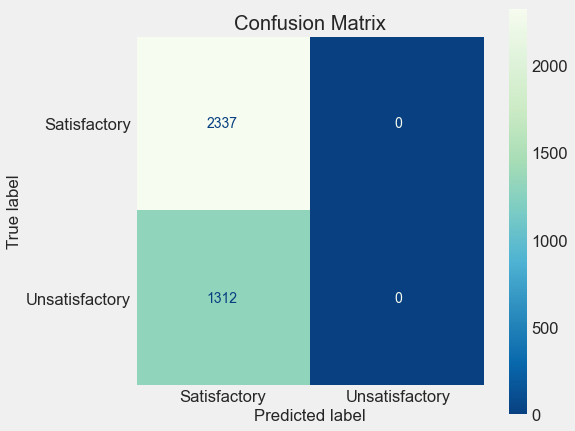

,Accuracy,F1,Recall,Precision
0,0.640449,0.0,0.0,0.0


time: 760 ms


In [23]:
%%capture --no-display
f.confusion_report(baseline, X_test, y_test, 'baseline')

## First Simple Model: Naive Bayes Classifier

In [24]:
mnb = MultinomialNB()

time: 851 µs


In [25]:
fsm = make_pipeline(preprocessing_ohe, mnb)

time: 1.59 ms


### Fitting Model

In [26]:
fsm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110ffa760>)])),
                ('multinomialnb', MultinomialNB())])

time: 99 ms


### Saving Model

In [27]:
# f.pickle_model(fsm, 'fsm')

time: 1.11 ms


### Cross Val Scores

In [28]:
# checking cross val scores
modeling.report(fsm, X_train, y_train, ' fsm', 'FSM Naive Bayes')

 fsm has an average Accuracy of 0.6447369805651159
 fsm has an average F1 of 0.27759213371791497
 fsm has an average Recall of 0.18978579583201646
 fsm has an average Precision of 0.5175573546203541


[0.6447369805651159,
 0.27759213371791497,
 0.18978579583201646,
 0.5175573546203541]

time: 473 ms


### Test Data Confusion Matrix

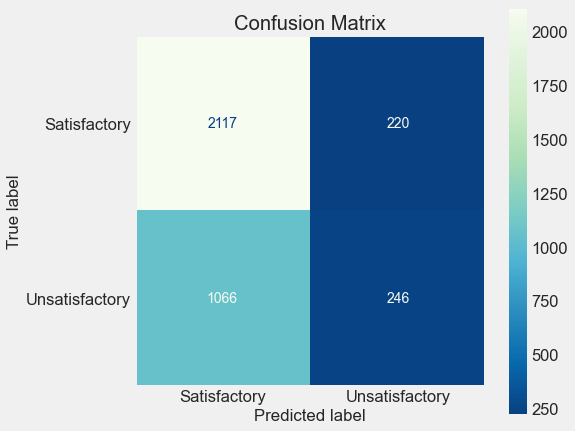

,Accuracy,F1,Recall,Precision
0,0.647575,0.276715,0.1875,0.527897


time: 695 ms


In [29]:
f.confusion_report(fsm, X_test, y_test, 'fsm')

# Standard Scaling

## KNeighborsClassifier

In [30]:
KNN = KNeighborsClassifier(n_jobs=-1)

time: 1.57 ms


In [31]:
knn_ss = make_pipeline(preprocessing_ss, KNN)

time: 1.18 ms


### Fitting Model

In [32]:
knn_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110ffa760>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110ffa700>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 84.2 ms


In [33]:
# f.pickle_model(knn_ss, 'knn_ss')

time: 655 µs


### Cross Val Scores

In [34]:
# checking cross val scores
modeling.report(knn_ss, X_train, y_train, 'knn_ss',\
                'KNN SS()')

knn_ss has an average Accuracy of 0.710343933394745
knn_ss has an average F1 of 0.5622362175375103
knn_ss has an average Recall of 0.5172808132147395
knn_ss has an average Precision of 0.6160075501796807


[0.710343933394745, 0.5622362175375103, 0.5172808132147395, 0.6160075501796807]

time: 6.45 s


### Test Data Confusion Matrix

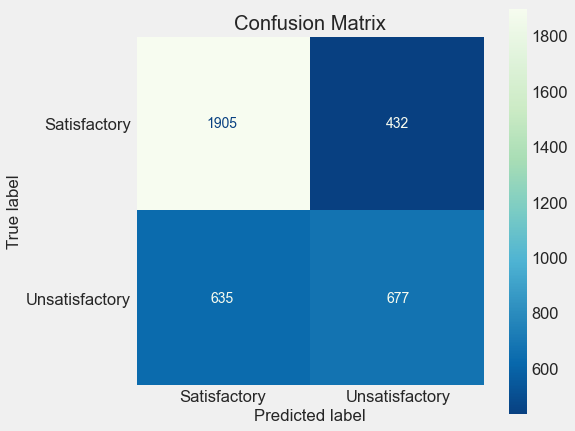

,Accuracy,F1,Recall,Precision
0,0.707591,0.559273,0.516006,0.61046


time: 12.6 s


In [35]:
f.confusion_report(knn_ss, X_test, y_test)

## Logistic Regression Classifier

In [36]:
LR = LogisticRegression(max_iter=1000, n_jobs=-1, random_state = 2021, verbose=0)

time: 952 µs


In [37]:
logreg_ss = make_pipeline(preprocessing_ss, LR)

time: 1.24 ms


### Fitting Model

In [38]:
logreg_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110ffa760>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110ffa700>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=2021))])

time: 3.99 s


In [39]:
# f.pickle_model(logreg_ss, 'logreg_ss')

time: 847 µs


### Cross Val Scores

In [40]:
# checking cross val scores
modeling.report(logreg_ss, X_train, y_train, 'logreg_ss',\
                'LogReg SS()')

logreg_ss has an average Accuracy of 0.7317252291038038
logreg_ss has an average F1 of 0.5708974826376763
logreg_ss has an average Recall of 0.496697605118712
logreg_ss has an average Precision of 0.671986979987122


[0.7317252291038038, 0.5708974826376763, 0.496697605118712, 0.671986979987122]

time: 2.62 s


### Test Data Confusion Matrix

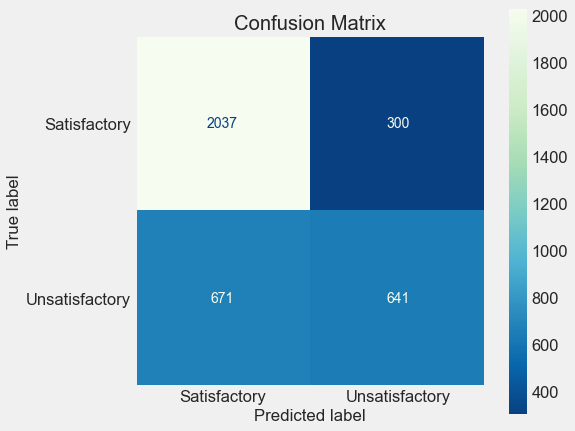

,Accuracy,F1,Recall,Precision
0,0.7339,0.569019,0.488567,0.68119


time: 278 ms


In [41]:
f.confusion_report(logreg_ss, X_test, y_test)

## Support Vector Machine

In [42]:
SVC = SVC()

time: 935 µs


In [43]:
svc_ss = make_pipeline(preprocessing_ss, SVC)

time: 1.05 ms


### Fitting Model

In [44]:
svc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110ffa760>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110ffa700>)])),
                ('svc', SVC())])

time: 6.12 s


In [45]:
# f.pickle_model(svc_ss, 'svc_ss')

time: 511 µs


### Cross Val Scores

In [46]:
# checking cross val scores
modeling.report(svc_ss, X_train, y_train, 'svc_ss',\
                'Support Vector CLF SS()')

svc_ss has an average Accuracy of 0.7444256766631896
svc_ss has an average F1 of 0.5863313032730525
svc_ss has an average Recall of 0.5040654286985855
svc_ss has an average Precision of 0.7013273063457831


[0.7444256766631896,
 0.5863313032730525,
 0.5040654286985855,
 0.7013273063457831]

time: 22.6 s


### Test Data Confusion Matrix

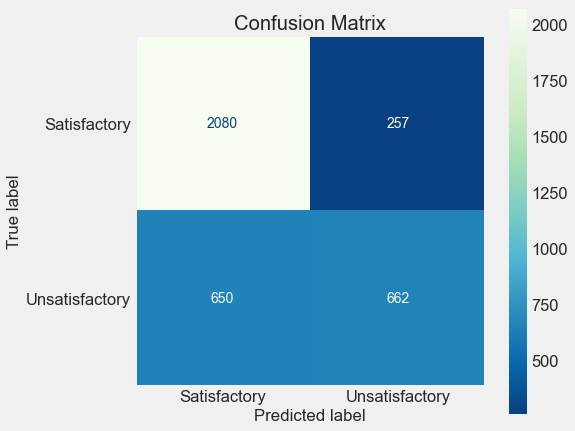

,Accuracy,F1,Recall,Precision
0,0.751439,0.593456,0.504573,0.720348


time: 6.33 s


In [47]:
f.confusion_report(svc_ss, X_test, y_test)

## Linear Support Vector Machine

In [48]:
LSVC = LinearSVC(random_state=2021)

time: 702 µs


In [49]:
lsvc_ss = make_pipeline(preprocessing_ss, LSVC)

time: 971 µs


### Fitting Model

In [50]:
lsvc_ss.fit(X_train, y_train)

/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110ffa760>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110ffa700>)])),
                ('linearsvc', LinearSVC(random_state=2021))])

time: 761 ms


In [51]:
# f.pickle_model(lsvc_ss, 'lsvc_ss')

time: 432 µs


### Cross Val Scores

In [52]:
# checking cross val scores
modeling.report(lsvc_ss, X_train, y_train, 'lsvc_ss',\
                'Linear SVC SS()')

/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


lsvc_ss has an average Accuracy of 0.7303546985383959
lsvc_ss has an average F1 of 0.5632846665047779
lsvc_ss has an average Recall of 0.48399402730925767
lsvc_ss has an average Precision of 0.6745561565674398


/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[0.7303546985383959,
 0.5632846665047779,
 0.48399402730925767,
 0.6745561565674398]

time: 2.76 s


### Test Data Confusion Matrix

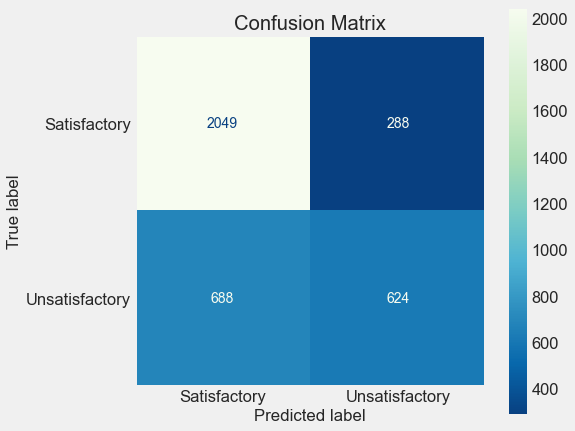

,Accuracy,F1,Recall,Precision
0,0.732529,0.561151,0.47561,0.684211


time: 239 ms


In [53]:
f.confusion_report(lsvc_ss, X_test, y_test)

## Decision Tree

In [54]:
DT = DecisionTreeClassifier(random_state=2021)

time: 705 µs


In [55]:
dt_ss = make_pipeline(preprocessing_ss, DT)

time: 648 µs


### Fitting Model

In [56]:
dt_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110ffa760>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110ffa700>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 469 ms


In [57]:
# f.pickle_model(dt_ss, 'dt_ss')

time: 547 µs


### Cross Val Scores

In [58]:
# checking cross val scores
modeling.report(dt_ss, X_train, y_train, 'dt_ss',\
                'Decision Tree CLF SS()')

dt_ss has an average Accuracy of 0.6856722535730004
dt_ss has an average F1 of 0.567441655954861
dt_ss has an average Recall of 0.5734270086881365
dt_ss has an average Precision of 0.5616731934970407


[0.6856722535730004, 0.567441655954861, 0.5734270086881365, 0.5616731934970407]

time: 1.72 s


### Test Data Confusion Matrix

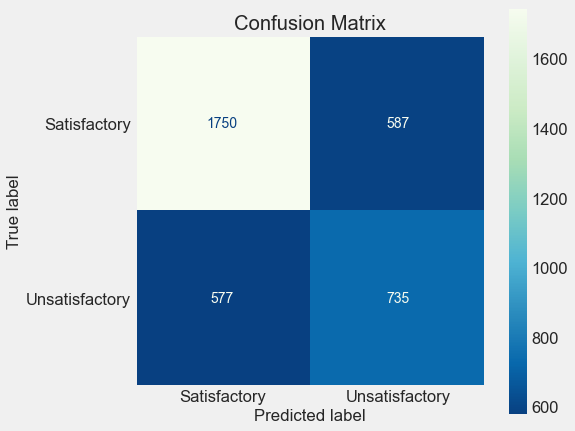

,Accuracy,F1,Recall,Precision
0,0.681008,0.558087,0.560213,0.555976


time: 213 ms


In [59]:
f.confusion_report(dt_ss, X_test, y_test)

## Bagging Classifier

In [60]:
BCLF = BaggingClassifier(base_estimator=DT, random_state=2021)

time: 653 µs


In [61]:
bclf_ss = make_pipeline(preprocessing_ss, BCLF)

time: 784 µs


### Fitting Model

In [62]:
bclf_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110ffa760>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110ffa700>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 2.95 s


In [63]:
# f.pickle_model(bclf_ss, 'bclf_ss')

time: 691 µs


### Cross Val Scores

In [64]:
# checking cross val scores
modeling.report(bclf_ss, X_train, y_train, 'bclf_ss',\
                'Bagging CLF SS()')

bclf_ss has an average Accuracy of 0.7477155596830756
bclf_ss has an average F1 of 0.6033710907163397
bclf_ss has an average Recall of 0.5337856926321765
bclf_ss has an average Precision of 0.6943330804123302


[0.7477155596830756,
 0.6033710907163397,
 0.5337856926321765,
 0.6943330804123302]

time: 12.2 s


### Test Data Confusion Matrix

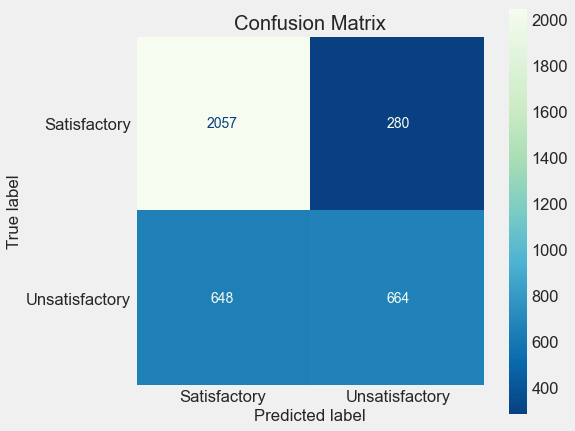

,Accuracy,F1,Recall,Precision
0,0.745684,0.588652,0.506098,0.70339


time: 274 ms


In [65]:
f.confusion_report(bclf_ss, X_test, y_test)

## Random Forest Classifier

In [66]:
RF = RandomForestClassifier(n_jobs=-1, random_state=2021)

time: 691 µs


In [67]:
rf_ss = make_pipeline(preprocessing_ss, RF)

time: 883 µs


### Fitting Model

In [68]:
rf_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110ffa760>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110ffa700>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 2.3 s


In [69]:
# f.pickle_model(rf_ss, 'rf_ss')

time: 514 µs


### Cross Val Scores

In [70]:
# checking cross val scores
modeling.report(rf_ss, X_train, y_train, 'rf_ss',\
                'Random Forest SS()')

rf_ss has an average Accuracy of 0.7580408691287583
rf_ss has an average F1 of 0.6262316744160861
rf_ss has an average Recall of 0.5637726636523713
rf_ss has an average Precision of 0.7046611733083759


[0.7580408691287583,
 0.6262316744160861,
 0.5637726636523713,
 0.7046611733083759]

time: 13.9 s


### Test Data Confusion Matrix

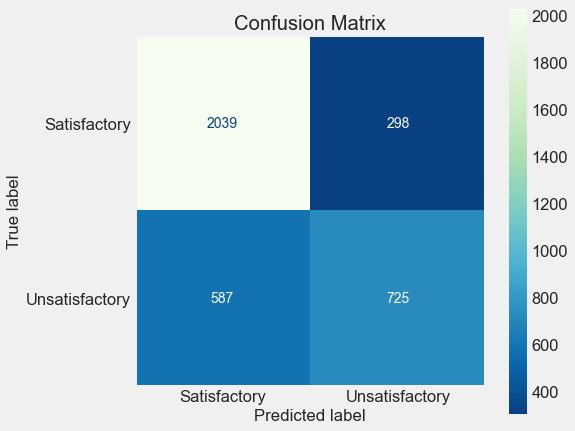

,Accuracy,F1,Recall,Precision
0,0.757468,0.620985,0.552591,0.7087


time: 540 ms


In [71]:
f.confusion_report(rf_ss, X_test, y_test)

## AdaBoost

In [72]:
ADA = AdaBoostClassifier(base_estimator=DT, random_state=2021)

time: 758 µs


In [73]:
ada_ss = make_pipeline(preprocessing_ss, ADA)

time: 768 µs


### Fitting Model

In [74]:
ada_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110ffa760>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110ffa700>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 480 ms


In [75]:
# f.pickle_model(ada_ss, 'ada_ss')

time: 848 µs


### Cross Val Scores

In [76]:
# checking cross val scores
modeling.report(ada_ss, X_train, y_train, 'ada_ss',\
                'AdaBoost SS()')

ada_ss has an average Accuracy of 0.6881395927618815
ada_ss has an average F1 of 0.5712699490285533
ada_ss has an average Recall of 0.5777446319958204
ada_ss has an average Precision of 0.5650618995678235


[0.6881395927618815,
 0.5712699490285533,
 0.5777446319958204,
 0.5650618995678235]

time: 1.8 s


### Test Data Confusion Matrix

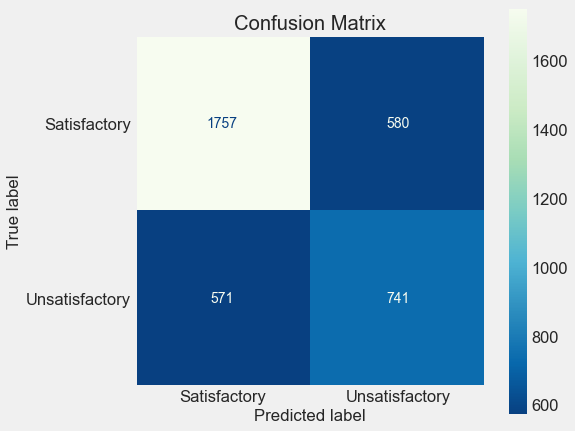

,Accuracy,F1,Recall,Precision
0,0.684571,0.562856,0.564787,0.560939


time: 253 ms


In [77]:
f.confusion_report(ada_ss, X_test, y_test)

## XGBoost

In [78]:
XGB = XGBClassifier(use_label_encoder=False, verbosity=0)

time: 802 µs


In [79]:
xgb_ss = make_pipeline(preprocessing_ss, XGB)

time: 1.56 ms


### Fitting Model

In [80]:
%%capture --no-display
xgb_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110ffa760>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110ffa700>)])),
                ('xgbclassifier',
                 XGBClassifie...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estima

time: 880 ms


In [81]:
# f.pickle_model(xgb_ss, 'xgb_ss')

time: 1.24 ms


### Cross Val Scores

In [82]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_ss, X_train, y_train, 'xgb_ss',\
                'XGBoost SS()')

[0.7572178659626869,
 0.6324830752160061,
 0.5807899947755082,
 0.6946373558267454]

time: 4.65 s


### Test Data Confusion Matrix

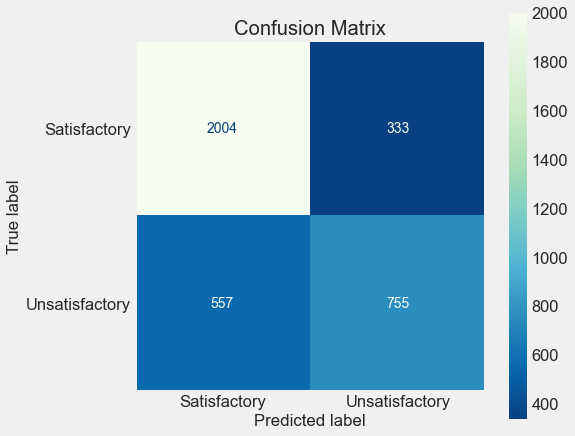

,Accuracy,F1,Recall,Precision
0,0.756098,0.629167,0.575457,0.693934


time: 422 ms


In [83]:
%%capture --no-display
f.confusion_report(xgb_ss, X_test, y_test)

## Model Summary

In [84]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.640351,0.000000,0.000000,0.000000,0.311785,Baseline DummyCFL
1,fsm,0.644737,0.277592,0.189786,0.517557,0.465037,FSM Naive Bayes
2,lsvc_ss,0.730355,0.563285,0.483994,0.674556,2.750617,Linear SVC SS()
3,logreg_ss,0.731725,0.570897,0.496698,0.671987,2.619234,LogReg SS()
4,svc_ss,0.744426,0.586331,0.504065,0.701327,22.557043,Support Vector CLF SS()
5,knn_ss,0.710344,0.562236,0.517281,0.616008,6.436267,KNN SS()
6,bclf_ss,0.747716,0.603371,0.533786,0.694333,12.236156,Bagging CLF SS()
7,rf_ss,0.758041,0.626232,0.563773,0.704661,13.924129,Random Forest SS()
8,dt_ss,0.685672,0.567442,0.573427,0.561673,1.717036,Decision Tree CLF SS()
9,ada_ss,0.688140,0.571270,0.577745,0.565062,1.794389,AdaBoost SS()


time: 11.1 ms


## Voting Classifier
Using the top three model in a voting classifier.

In [85]:
clf1 = BCLF
clf2 = RF
clf3 = XGB

estimators = [('bclf',clf1), ('rf', clf2), ('xgb', clf3)]

VC = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)

time: 1.13 ms


In [86]:
vc_ss = make_pipeline(preprocessing_ss, VC)

time: 1.05 ms


### Fitting Model

In [87]:
%%capture --no-display
vc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110ffa760>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110ffa700>)])),
                ('votingclassifier',
                 VotingCla...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
   

time: 6.25 s


In [88]:
# f.pickle_model(vc_ss, 'vc_ss')

time: 813 µs


### Cross Val Scores

In [89]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_ss, X_train, y_train, 'vc_ss',\
                'Voting CLF SS()')

[0.7640708946093272,
 0.6402318177517269,
 0.5838382600506968,
 0.7091504825134183]

time: 23.4 s


### Test Data Confusion Matrix

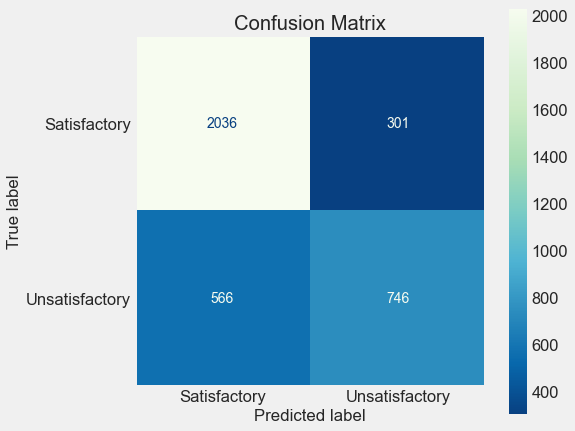

,Accuracy,F1,Recall,Precision
0,0.762401,0.632471,0.568598,0.712512


time: 855 ms


In [90]:
%%capture --no-display
f.confusion_report(vc_ss, X_test, y_test)

## Model Summary

In [91]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.640351,0.000000,0.000000,0.000000,0.311785,Baseline DummyCFL
1,fsm,0.644737,0.277592,0.189786,0.517557,0.465037,FSM Naive Bayes
2,lsvc_ss,0.730355,0.563285,0.483994,0.674556,2.750617,Linear SVC SS()
3,logreg_ss,0.731725,0.570897,0.496698,0.671987,2.619234,LogReg SS()
4,svc_ss,0.744426,0.586331,0.504065,0.701327,22.557043,Support Vector CLF SS()
5,knn_ss,0.710344,0.562236,0.517281,0.616008,6.436267,KNN SS()
6,bclf_ss,0.747716,0.603371,0.533786,0.694333,12.236156,Bagging CLF SS()
7,rf_ss,0.758041,0.626232,0.563773,0.704661,13.924129,Random Forest SS()
8,dt_ss,0.685672,0.567442,0.573427,0.561673,1.717036,Decision Tree CLF SS()
9,ada_ss,0.688140,0.571270,0.577745,0.565062,1.794389,AdaBoost SS()


time: 8.52 ms


## SMOTE

## XGBoost SMOTE

In [92]:
xgb_sm = make_sm_pipeline(preprocessing_ss, sm, XGB)

time: 925 µs


### Fitting Model

In [93]:
%%capture --no-display
xgb_sm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110ffa760>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110ffa700>)])),
                ('smote', SMOTE(random_state=2...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
       

time: 2.22 s


In [94]:
# f.pickle_model(xgb_sm, 'xgb_sm')

time: 940 µs


### Cross Val Scores

In [95]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_sm, X_train, y_train, 'xgb_sm',\
                'XGBoost SS()/SMOTE')

[0.761147143395221, 0.6485159757332217, 0.6128080676474952, 0.6889483694755145]

time: 9.33 s


### Test Data Confusion Matrix

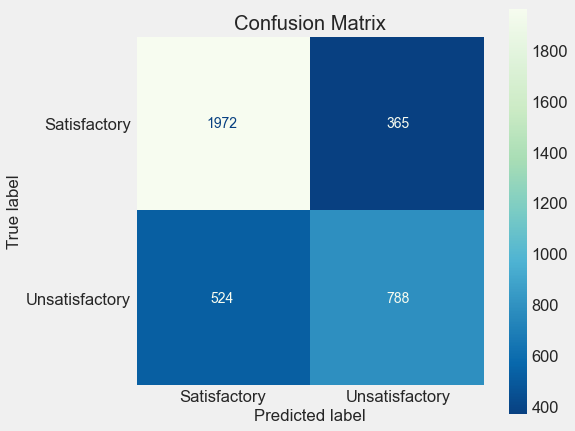

,Accuracy,F1,Recall,Precision
0,0.756372,0.639351,0.60061,0.683435


time: 478 ms


In [96]:
%%capture --no-display
f.confusion_report(xgb_sm, X_test, y_test)

## Voting CLF SMOTE

In [97]:
clf1 = BCLF
clf2 = RF
clf3 = XGB

estimators = [ ('bclf', clf1), ('rf', clf2), ('xgb', clf3)]
VC = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)

time: 1.22 ms


In [98]:
vc_ss = make_sm_pipeline(preprocessing_ss, sm, VC)

time: 989 µs


### Fitting Model

In [99]:
%%capture --no-display
vc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110ffa760>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110ffa700>)])),
                ('smote', SMOTE(random_state=2...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
                    

time: 10.2 s


In [100]:
# f.pickle_model(vc_ss, 'vc_ss')

time: 515 µs


### Cross Val Scores

In [101]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_ss, X_train, y_train, 'vc_ss',\
                'Voting CLF SS()/SMOTE SOFT')

[0.7615122730154009, 0.6585042104593446, 0.6394797438063972, 0.678897497764228]

time: 34.4 s


### Test Data Confusion Matrix

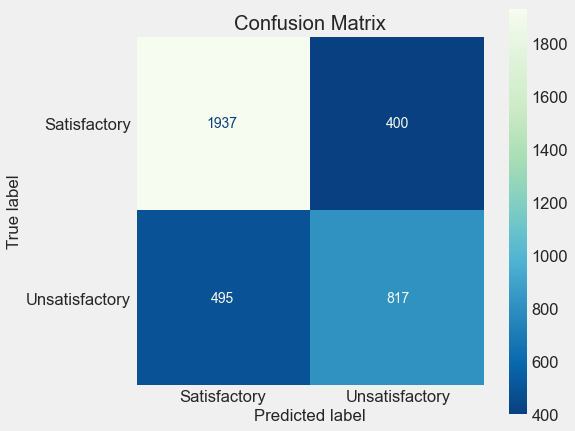

,Accuracy,F1,Recall,Precision
0,0.754727,0.646105,0.622713,0.671323


time: 771 ms


In [102]:
%%capture --no-display
f.confusion_report(vc_ss, X_test, y_test)

## Model Summary

In [103]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.640351,0.000000,0.000000,0.000000,0.311785,Baseline DummyCFL
1,fsm,0.644737,0.277592,0.189786,0.517557,0.465037,FSM Naive Bayes
2,lsvc_ss,0.730355,0.563285,0.483994,0.674556,2.750617,Linear SVC SS()
3,logreg_ss,0.731725,0.570897,0.496698,0.671987,2.619234,LogReg SS()
4,svc_ss,0.744426,0.586331,0.504065,0.701327,22.557043,Support Vector CLF SS()
5,knn_ss,0.710344,0.562236,0.517281,0.616008,6.436267,KNN SS()
6,bclf_ss,0.747716,0.603371,0.533786,0.694333,12.236156,Bagging CLF SS()
7,rf_ss,0.758041,0.626232,0.563773,0.704661,13.924129,Random Forest SS()
8,dt_ss,0.685672,0.567442,0.573427,0.561673,1.717036,Decision Tree CLF SS()
9,ada_ss,0.688140,0.571270,0.577745,0.565062,1.794389,AdaBoost SS()


time: 10.8 ms


## Feature Importances

## XGBoost

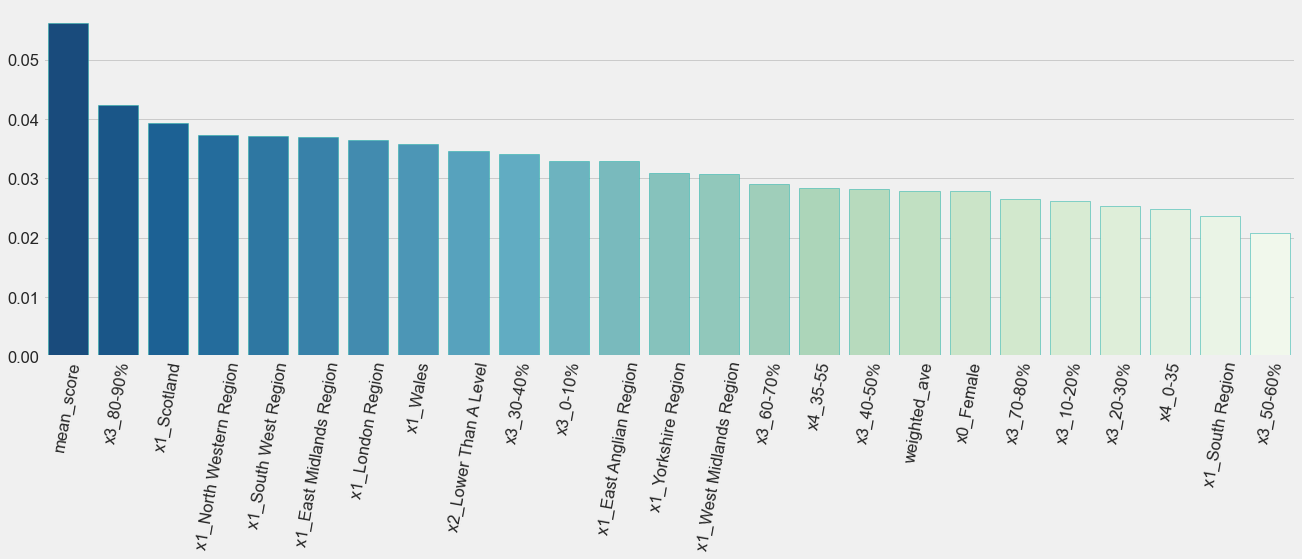

time: 398 ms


In [104]:
v.importance_plot_sm(xgb_sm, X_train)

In [105]:
# feature legend
keys = range(12)
f.get_features(keys, X_train)

0 gender
1 region
2 highest_education
3 imd_band
4 age_band
5 num_of_prev_attempts
6 disability
7 weighted_ave
8 mean_score
9 median_score
10 sum_activity
11 course_load
time: 1.67 ms


## Bagging Classifier

In [106]:
bclf_sm = make_sm_pipeline(preprocessing_ss, BCLF)
bclf_sm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110ffa760>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110ffa700>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 3.01 s


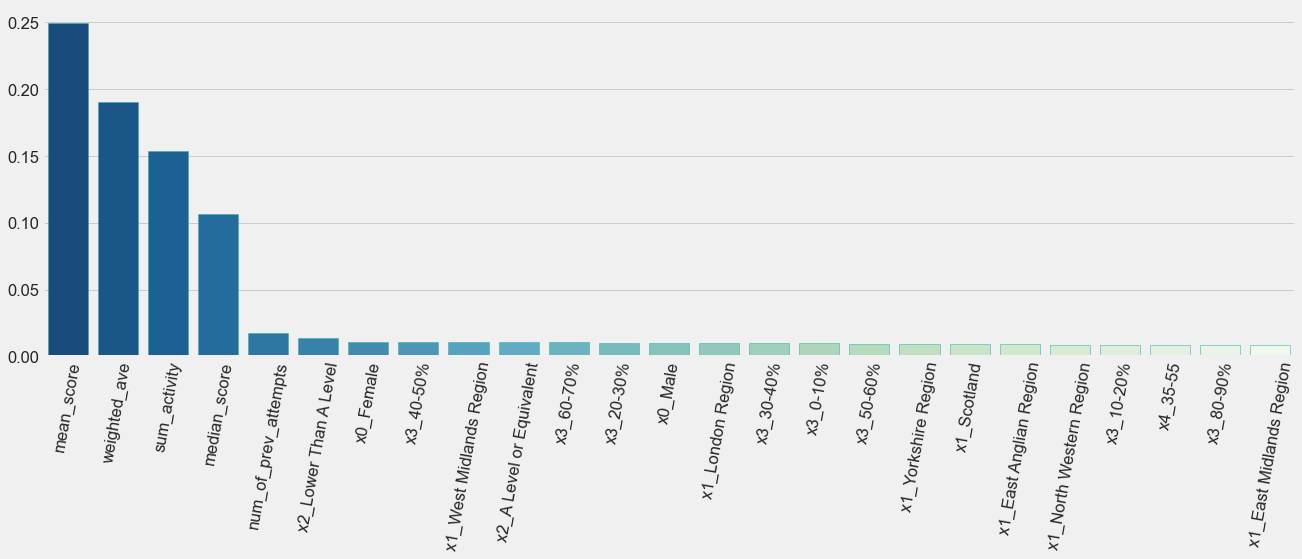

time: 304 ms


In [107]:
v.importance_plot_bclf(bclf_sm, X_train)

## Random Forest Classifier

In [108]:
rf_sm = make_sm_pipeline(preprocessing_ss, RF)
rf_sm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110ffa760>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110ffa700>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 2.26 s


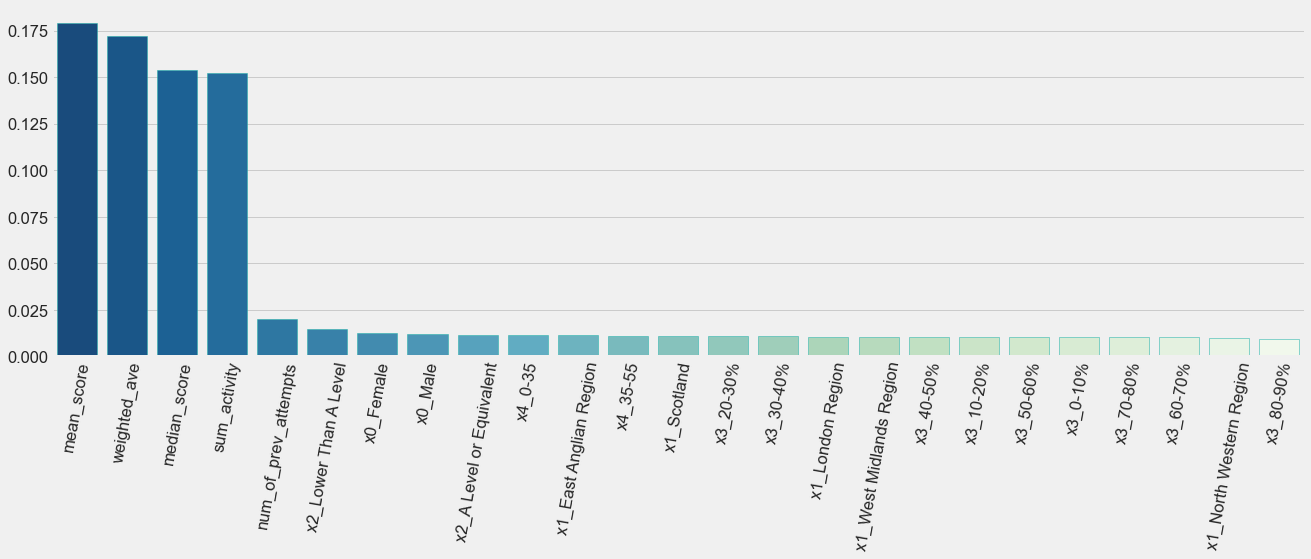

time: 338 ms


In [109]:
v.importance_plot(rf_sm, X_train)

## Permutation Importances

## Accuracy

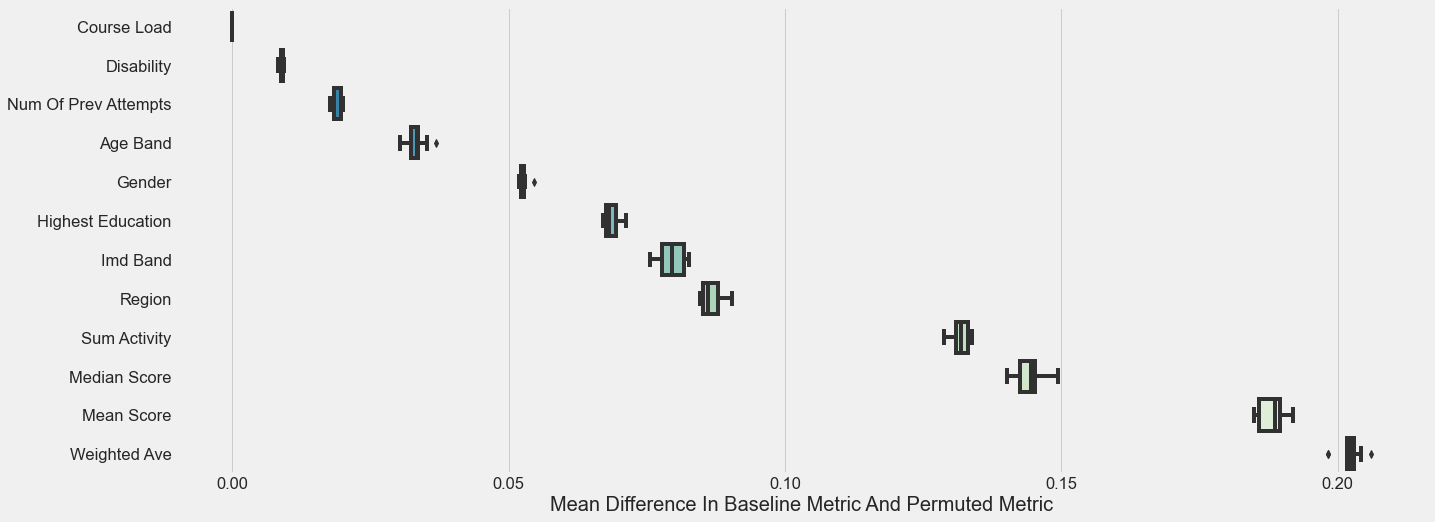

time: 22.1 s


In [110]:
f.perm_importances(vc_ss, X_train, y_train, 'accuracy')

## F1

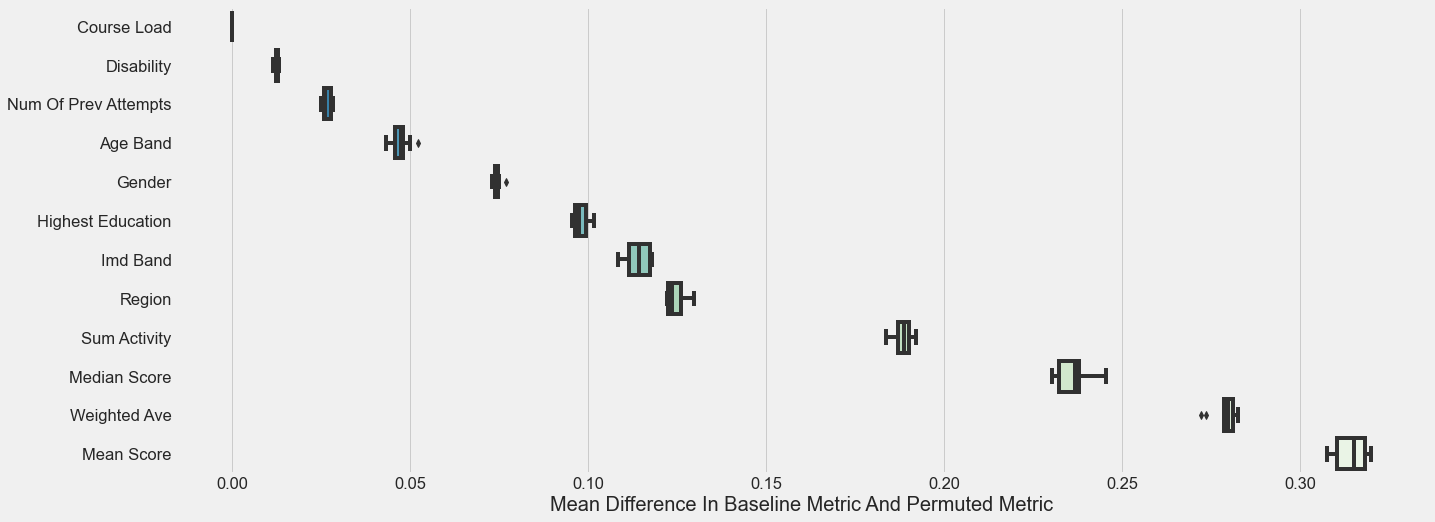

time: 20.2 s


In [111]:
f.perm_importances(vc_ss, X_train, y_train, 'f1')

## Recall

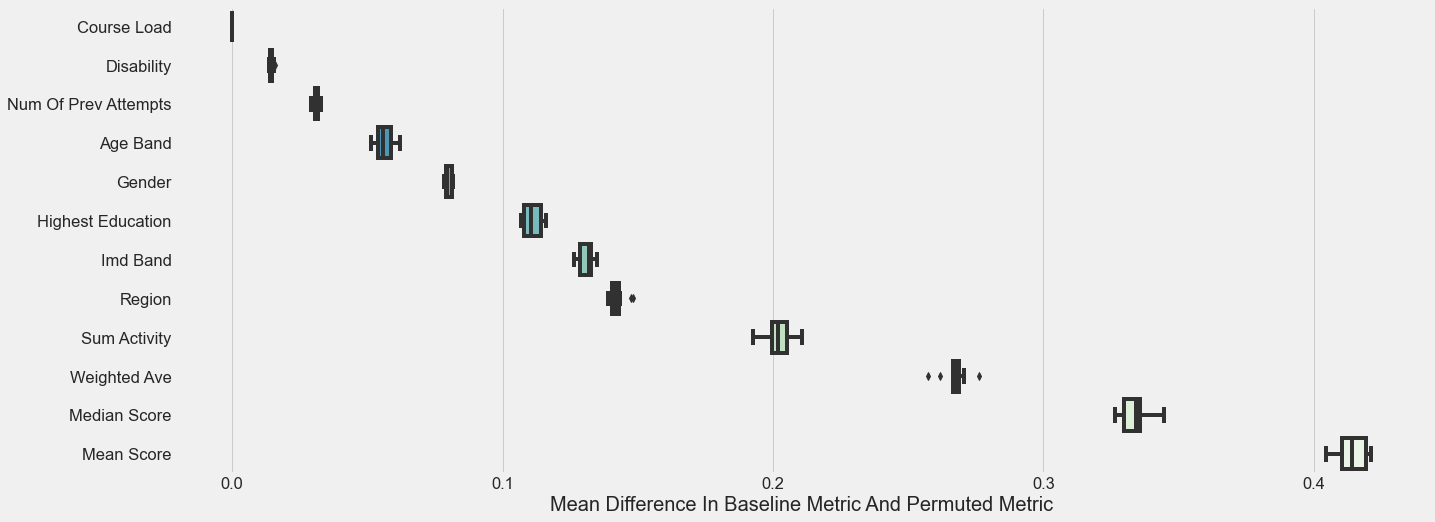

time: 19.2 s


In [112]:
f.perm_importances(vc_ss, X_train, y_train, 'recall')

## Precision

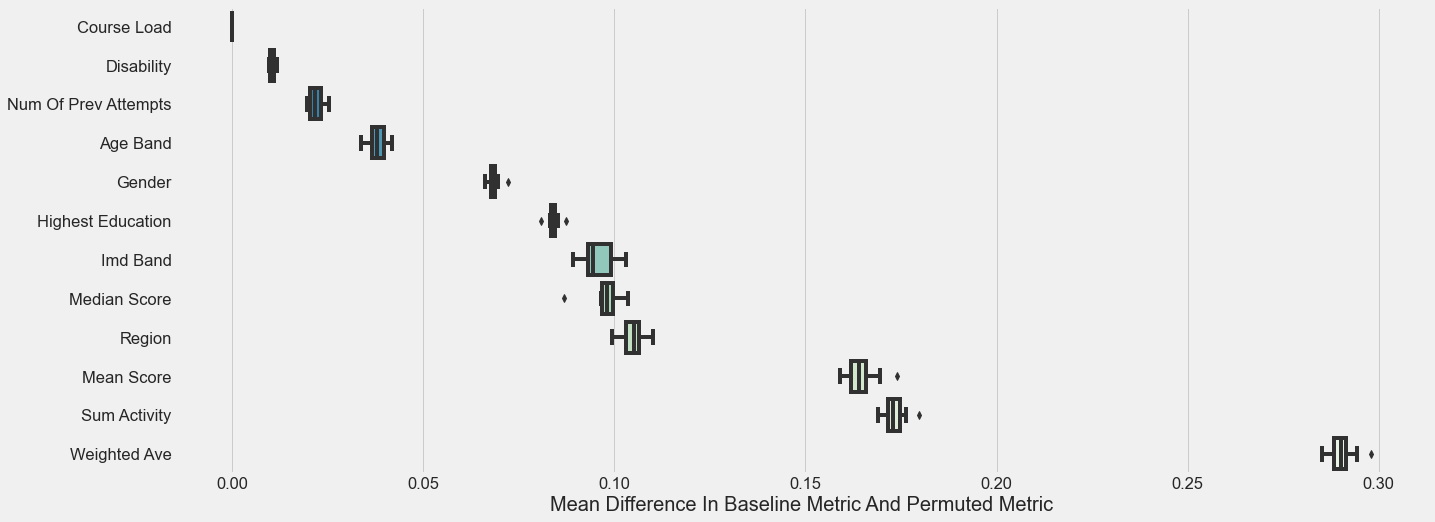

time: 19.2 s


In [113]:
f.perm_importances(vc_ss, X_train, y_train, 'precision')

In [114]:
# getting params
vc_ss.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'smote', 'votingclassifier', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__onehotencoder', 'columntransformer__standardscaler', 'columntransformer__onehotencoder__categories', 'columntransformer__onehotencoder__drop', 'columntransformer__onehotencoder__dtype', 'columntransformer__onehotencoder__handle_unknown', 'columntransformer__onehotencoder__sparse', 'columntransformer__standardscaler__copy', 'columntransformer__standardscaler__with_mean', 'columntransformer__standardscaler__with_std', 'smote__k_neighbors', 'smote__n_jobs', 'smote__random_state', 'smote__sampling_strategy', 'votingclassifier__estimators', 'votingclassifier__flatten_transform', 'votingclassifier__n_jobs', 'votingclassifier__verbose', 'votingclassifier__voting', 'votingclassifie

time: 5.51 ms


In [115]:
bag_params = ['votingclassifier__bclf__base_estimator__ccp_alpha', 
              'votingclassifier__bclf__base_estimator__class_weight',
              'votingclassifier__bclf__base_estimator__criterion', 
              'votingclassifier__bclf__base_estimator__max_depth', 
              'votingclassifier__bclf__base_estimator__max_features', 
              'votingclassifier__bclf__base_estimator__max_leaf_nodes', 
              'votingclassifier__bclf__base_estimator__min_impurity_decrease', 
              'votingclassifier__bclf__base_estimator__min_impurity_split', 
              'votingclassifier__bclf__base_estimator__min_samples_leaf', 
              'votingclassifier__bclf__base_estimator__min_samples_split', 
              'votingclassifier__bclf__base_estimator__min_weight_fraction_leaf', 
              'votingclassifier__bclf__base_estimator__random_state', 
              'votingclassifier__bclf__base_estimator__splitter', 
              'votingclassifier__bclf__base_estimator', 
              'votingclassifier__bclf__bootstrap', 
              'votingclassifier__bclf__bootstrap_features', 
              'votingclassifier__bclf__max_features', 
              'votingclassifier__bclf__max_samples',
              'votingclassifier__bclf__n_estimators', 
              'votingclassifier__bclf__n_jobs', 
              'votingclassifier__bclf__oob_score', 
              'votingclassifier__bclf__random_state', 
              'votingclassifier__bclf__verbose', 
              'votingclassifier__bclf__warm_start']

time: 1.6 ms


In [116]:
rf_params = ['votingclassifier__rf__bootstrap',
             'votingclassifier__rf__ccp_alpha', 
             'votingclassifier__rf__class_weight', 
             'votingclassifier__rf__criterion', 
             'votingclassifier__rf__max_depth', 
             'votingclassifier__rf__max_features', 
             'votingclassifier__rf__max_leaf_nodes', 
             'votingclassifier__rf__max_samples', 
             'votingclassifier__rf__min_impurity_decrease', 
             'votingclassifier__rf__min_impurity_split', 
             'votingclassifier__rf__min_samples_leaf', 
             'votingclassifier__rf__min_samples_split', 
             'votingclassifier__rf__min_weight_fraction_leaf', 
             'votingclassifier__rf__n_estimators', 
             'votingclassifier__rf__n_jobs', 
             'votingclassifier__rf__oob_score', 
             'votingclassifier__rf__random_state', 
             'votingclassifier__rf__verbose',
             'votingclassifier__rf__warm_start']

time: 1.4 ms


In [117]:
xgb_params = ['votingclassifier__xgb__objective', 
              'votingclassifier__xgb__use_label_encoder', 
              'votingclassifier__xgb__base_score', 
              'votingclassifier__xgb__booster', 
              'votingclassifier__xgb__colsample_bylevel', 
              'votingclassifier__xgb__colsample_bynode', 
              'votingclassifier__xgb__colsample_bytree', 
              'votingclassifier__xgb__gamma', 
              'votingclassifier__xgb__gpu_id', 
              'votingclassifier__xgb__importance_type', 
              'votingclassifier__xgb__interaction_constraints', 
              'votingclassifier__xgb__learning_rate', 
              'votingclassifier__xgb__max_delta_step', 
              'votingclassifier__xgb__max_depth', 
              'votingclassifier__xgb__min_child_weight', 
              'votingclassifier__xgb__missing', 
              'votingclassifier__xgb__monotone_constraints', 
              'votingclassifier__xgb__n_estimators', 
              'votingclassifier__xgb__n_jobs', 
              'votingclassifier__xgb__num_parallel_tree', 
              'votingclassifier__xgb__random_state', 
              'votingclassifier__xgb__reg_alpha', 
              'votingclassifier__xgb__reg_lambda', 
              'votingclassifier__xgb__scale_pos_weight', 
              'votingclassifier__xgb__subsample', 
              'votingclassifier__xgb__tree_method', 
              'votingclassifier__xgb__validate_parameters', 
              'votingclassifier__xgb__verbosity']

time: 1.5 ms


In [118]:
# setting param grid

grid = {'votingclassifier__bclf__base_estimator__max_depth':\
        np.linspace(1, 32, 32),
        'votingclassifier__bclf__base_estimator__min_samples_split':\
        np.linspace(0.1, 1.0, 10),
        'votingclassifier__bclf__base_estimator__min_samples_leaf':\
        np.linspace(0.1, 0.5, 5),
        'votingclassifier__bclf__max_features':\
        list(range(1,X_train.shape[1])),
        'votingclassifier__rf__n_estimators':\
        np.linspace(1, 200, 20, dtype='int'),
        'votingclassifier__rf__max_depth':\
        np.linspace(1, 32, 32),
        'votingclassifier__rf__max_features':\
        list(range(1,X_train.shape[1])),
        'votingclassifier__rf__min_samples_leaf':\
        np.linspace(0.1, 0.5, 5),
        'votingclassifier__rf__min_samples_split':\
        np.linspace(0.1, 1.0, 10),
        'votingclassifier__xgb__n_estimators':\
        np.linspace(1, 200, 20, dtype='int'),
        'votingclassifier__xgb__colsample_bytree':\
        np.linspace(0.5, 1.0, 10),
        'votingclassifier__xgb__gamma':\
        np.linspace(0, .5, 5),
        'votingclassifier__xgb__learning_rate':\
        np.linspace(0.01, .5, 10),
        'votingclassifier__xgb__max_depth':\
        np.linspace(3, 10, 7, dtype='int'),
        'votingclassifier__xgb__reg_alpha':\
        np.logspace(.001, 2, 10),
        'votingclassifier__xgb__reg_lambda':\
        np.linspace(1, 10, 20)
       }

time: 5.52 ms


In [119]:
# instantiating RSCV
param_search = RandomizedSearchCV(vc_ss, param_distributions=grid,
                                  scoring='f1', random_state=2021, cv=10)

time: 955 µs


In [120]:
# fitting RSCV
param_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('onehotencoder',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x110ffa760>),
                                                                              ('standardscaler',
                                                                               StandardScaler(),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x110ffa700...
                                        'votingclassifier__xgb__reg_alpha': array([  1.00230524,   1.67151821,   2.78754715,   4.64871941,
         7.75254765,  12.92872076, 

time: 3min 22s


In [121]:
# creating search results dataframe
search_results = pd.DataFrame(param_search.cv_results_)\
.sort_values(by='rank_test_score').reset_index(drop=True)

time: 4.07 ms


In [122]:
# checking first five rows
search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_votingclassifier__xgb__reg_lambda,param_votingclassifier__xgb__reg_alpha,param_votingclassifier__xgb__n_estimators,param_votingclassifier__xgb__max_depth,param_votingclassifier__xgb__learning_rate,param_votingclassifier__xgb__gamma,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,1.558475,0.163611,0.035060,0.002377,3.842105,7.752548,21,10,0.173333,0.125,...,0.679790,0.683311,0.658945,0.649418,0.659119,0.667516,0.628571,0.658598,0.019757,1
1,1.670802,0.258423,0.038889,0.006670,7.157895,100.0,42,6,0.336667,0.25,...,0.661939,0.691244,0.656036,0.630359,0.659817,0.681344,0.628571,0.655359,0.020572,2
2,1.908631,0.122420,0.066694,0.006308,3.368421,1.671518,137,3,0.5,0.125,...,0.664865,0.673025,0.649664,0.657682,0.647137,0.665779,0.642473,0.655102,0.019683,3
3,1.711398,0.298033,0.078523,0.007360,5.263158,1.671518,11,8,0.064444,0.5,...,0.664286,0.665871,0.650463,0.629847,0.651163,0.674528,0.639816,0.652681,0.015556,4
4,2.019104,0.102295,0.078364,0.005080,1.947368,21.560889,74,5,0.118889,0.25,...,0.659767,0.677043,0.646388,0.641849,0.668305,0.681648,0.613435,0.652614,0.022117,5


time: 22.9 ms


In [123]:
# checking best params
param_search.best_params_

{'votingclassifier__xgb__reg_lambda': 3.8421052631578947,
 'votingclassifier__xgb__reg_alpha': 7.75254765345907,
 'votingclassifier__xgb__n_estimators': 21,
 'votingclassifier__xgb__max_depth': 10,
 'votingclassifier__xgb__learning_rate': 0.17333333333333334,
 'votingclassifier__xgb__gamma': 0.125,
 'votingclassifier__xgb__colsample_bytree': 0.8888888888888888,
 'votingclassifier__rf__n_estimators': 53,
 'votingclassifier__rf__min_samples_split': 0.1,
 'votingclassifier__rf__min_samples_leaf': 0.5,
 'votingclassifier__rf__max_features': 4,
 'votingclassifier__rf__max_depth': 27.0,
 'votingclassifier__bclf__max_features': 4,
 'votingclassifier__bclf__base_estimator__min_samples_split': 0.2,
 'votingclassifier__bclf__base_estimator__min_samples_leaf': 0.5,
 'votingclassifier__bclf__base_estimator__max_depth': 21.0}

time: 3.26 ms


## Params

best_params = {'votingclassifier__xgb__reg_lambda': 3.8421052631578947,
 'votingclassifier__xgb__reg_alpha': 7.75254765345907,
 'votingclassifier__xgb__n_estimators': 21,
 'votingclassifier__xgb__max_depth': 10,
 'votingclassifier__xgb__learning_rate': 0.17333333333333334,
 'votingclassifier__xgb__gamma': 0.125,
 'votingclassifier__xgb__colsample_bytree': 0.8888888888888888,
 'votingclassifier__rf__n_estimators': 53,
 'votingclassifier__rf__min_samples_split': 0.1,
 'votingclassifier__rf__min_samples_leaf': 0.5,
 'votingclassifier__rf__max_features': 4,
 'votingclassifier__rf__max_depth': 27.0,
 'votingclassifier__bclf__max_features': 4,
 'votingclassifier__bclf__base_estimator__min_samples_split': 0.2,
 'votingclassifier__bclf__base_estimator__min_samples_leaf': 0.5,
 'votingclassifier__bclf__base_estimator__max_depth': 21.0}
 
ACC 0.767608 F1 0.669782 RC 0.655488 PR 0.684713

In [124]:
best_params = {'votingclassifier__xgb__reg_lambda': 3.8421052631578947,
 'votingclassifier__xgb__reg_alpha': 7.75254765345907,
 'votingclassifier__xgb__n_estimators': 21,
 'votingclassifier__xgb__max_depth': 10,
 'votingclassifier__xgb__learning_rate': 0.17333333333333334,
 'votingclassifier__xgb__gamma': 0.125,
 'votingclassifier__xgb__colsample_bytree': 0.8888888888888888,
 'votingclassifier__rf__n_estimators': 53,
 'votingclassifier__rf__min_samples_split': 0.1,
 'votingclassifier__rf__min_samples_leaf': 0.5,
 'votingclassifier__rf__max_features': 4,
 'votingclassifier__rf__max_depth': 27.0,
 'votingclassifier__bclf__max_features': 4,
 'votingclassifier__bclf__base_estimator__min_samples_split': 0.2,
 'votingclassifier__bclf__base_estimator__min_samples_leaf': 0.5,
 'votingclassifier__bclf__base_estimator__max_depth': 21.0}

time: 1.46 ms


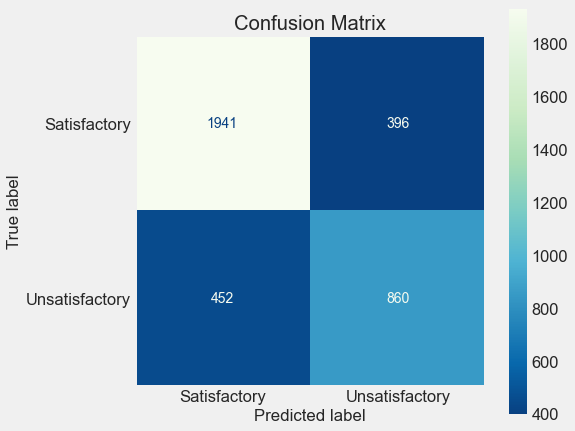

,Accuracy,F1,Recall,Precision
0,0.767608,0.669782,0.655488,0.684713


time: 412 ms


In [129]:
# getting best estimator
best_model = param_search.best_estimator_

# checking metrics on test data
f.confusion_report(best_model, X_test, y_test)

## Saving Model

In [127]:
# f.pickle_model(best_model, 'xgb2_f1_tuned')

time: 581 µs


## ROC AUC Test

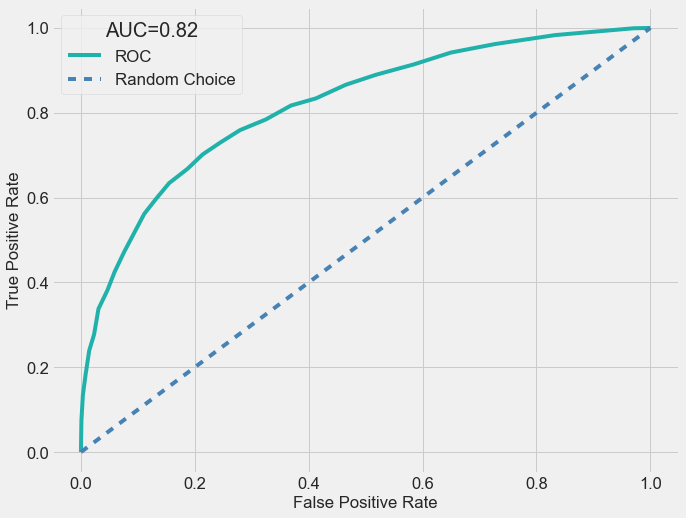

time: 894 ms


In [128]:
f.roc_auc(best_model, X_test, y_test)